In [1]:
import pickle

from scipy.stats import norm
from scipy.stats import iqr

import numpy as np
import pymc3 as pm
import theano.tensor as tt
import pymbar

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
SEED = 428
SIZE = 20

SMC_STEPS = 50000
MET_STEPS = 50000

[mu]
[mu]
[mu, sigma_interval__]


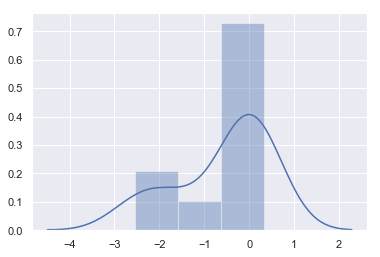

In [3]:
rnd = np.random.RandomState(SEED)
x = rnd.normal(loc=0, scale=1, size=10)
sns.distplot(x)

with pm.Model() as model_1:
    mu = pm.Normal("mu", mu=3, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=x)
print(model_1.vars)

with pm.Model() as model_2:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=x)
print(model_2.vars)

with pm.Model() as model_3:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0.5, upper=2)
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=x)
print(model_3.vars)

# Sequential Monte Carlo

In [4]:
def bayes_factor_smc(model_ini, model_fin):
    log_bf = np.log10(model_fin.marginal_likelihood) - np.log10(model_ini.marginal_likelihood)
    return log_bf

Sample initial stage: ...
Stage: 0 Beta: 0.034 Steps: 25
Stage: 1 Beta: 0.090 Steps: 4
Stage: 2 Beta: 0.194 Steps: 3
Stage: 3 Beta: 0.423 Steps: 4
Stage: 4 Beta: 1.000 Steps: 3


Log10 marginal likelihood: -9.18477


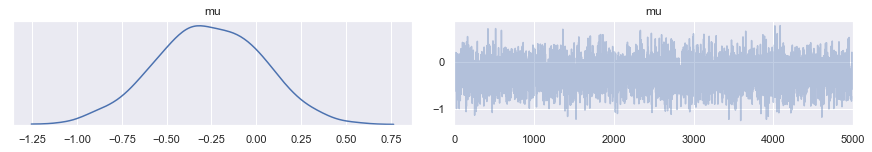

In [5]:
with model_1:
    trace_m1 = pm.sample(SMC_STEPS, step=pm.SMC())
pm.traceplot(trace_m1[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_1.marginal_likelihood)))

Sample initial stage: ...
Stage: 0 Beta: 0.455 Steps: 25
Stage: 1 Beta: 1.000 Steps: 4


Log10 marginal likelihood: -6.70859


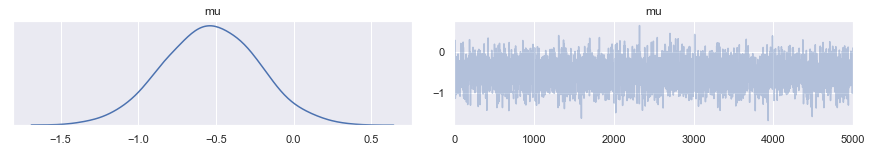

In [6]:
with model_2:
    trace_m2 = pm.sample(SMC_STEPS, step=pm.SMC())
pm.traceplot(trace_m2[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_2.marginal_likelihood)) )

Sample initial stage: ...
Stage: 0 Beta: 0.422 Steps: 25
Stage: 1 Beta: 1.000 Steps: 7


Log10 marginal likelihood: -7.06104


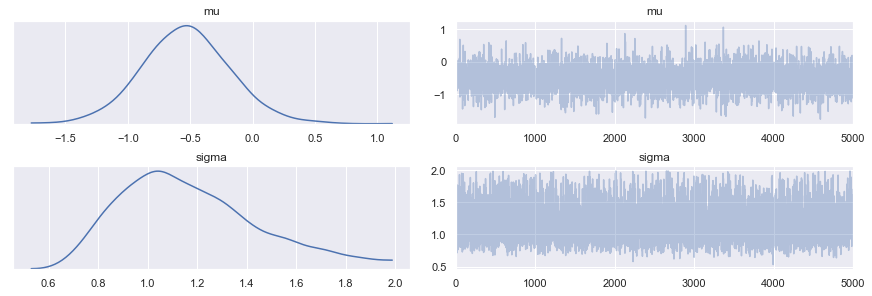

In [8]:
with model_3:
    trace_m3 = pm.sample(SMC_STEPS, step=pm.SMC())
pm.traceplot(trace_m3[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_3.marginal_likelihood)) )

In [9]:
bf_smc_2_vs_1 = bayes_factor_smc(model_1, model_2)
print("Log10 of Bayes factor model 2 over model 1: %0.5f" % bf_smc_2_vs_1)

bf_smc_3_vs_2 = bayes_factor_smc(model_2, model_3)
print("Log10 of Bayes factor model 3 over model 2: %0.5f" % bf_smc_3_vs_2)

Log10 of Bayes factor model 2 over model 1: 2.47618
Log10 of Bayes factor model 3 over model 2: -0.35245


# BAR estimator

In [10]:
def dict_to_list(dict_of_list):
    """
    :param dict_of_list: dict: varname --> ndarray
    :return: list of dic: [ {varname: float, ...}, ...  ]
    """
    keys = list(dict_of_list.keys())
    key0 = keys[0]
    for key in keys[1:]:
        assert len(dict_of_list[key0]) == len(dict_of_list[key]), key0 + " and " + key + " do not have same len."

    n = len(dict_of_list[key0])
    ls_of_dic = []
    for i in range(n):
        dic = {key: dict_of_list[key][i] for key in keys}
        ls_of_dic.append(dic)
    return ls_of_dic


def get_values_from_trace(model, trace, burn=0):
    varnames = [var.name for var in model.vars]
    trace_values = {var: trace.get_values(var, burn=burn) for var in varnames}
    return trace_values

In [11]:
def fit_normal(x, sigma_robust=False):
    mu, sigma = norm.fit(x)
    if sigma_robust:
        sigma = std_from_iqr(x)
    res = {"mu": mu, "sigma": sigma}
    return res


def fit_normal_trace(trace_values, sigma_robust=False):
    res = {varname: fit_normal(trace_values[varname], sigma_robust=sigma_robust) for varname in trace_values}
    return res


def draw_normal_samples(mu_sigma_dict, nsamples, random_state=None):
    rand = np.random.RandomState(random_state)
    keys = mu_sigma_dict.keys()
    samples = {k: rand.normal(loc=mu_sigma_dict[k]["mu"], scale=mu_sigma_dict[k]["sigma"], size=nsamples)
               for k in keys}
    return samples


def log_normal_pdf(mu, sigma, y):
    sigma2 = sigma * sigma
    res = - 0.5 * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * (y - mu) ** 2
    return res


def log_normal_trace(trace_val, mu_sigma_dict):
    keys = list(trace_val.keys())
    if len(keys) == 0:
        return 0.
    
    k0 = keys[0]
    for k in keys[1:]:
        assert len(trace_val[k0]) == len(trace_val[k]), k0 + " and " + k + " do not have same len."

    nsamples = len(trace_val[k0])
    logp = np.zeros(nsamples, dtype=float)
    for k in keys:
        mu = mu_sigma_dict[k]["mu"]
        sigma = mu_sigma_dict[k]["sigma"]
        y = trace_val[k]
        logp += log_normal_pdf(mu, sigma, y)

    return logp

In [12]:
def fit_uniform(x, d=1e-20):
    lower = x.min() - d
    upper = x.max() + d
    res = {"lower": lower, "upper": upper}
    return res


def fit_uniform_trace(trace_values):
    res = {varname: fit_uniform(trace_values[varname]) for varname in trace_values}
    return res


def draw_uniform_samples(lower_upper_dict, nsamples, random_state=None):
    rand = np.random.RandomState(random_state)
    keys = lower_upper_dict.keys()
    samples = {k: rand.uniform(low=lower_upper_dict[k]["lower"], 
                               high=lower_upper_dict[k]["upper"], 
                               size=nsamples)
               for k in keys}
    return samples


def log_uniform_pdf(lower, upper, y):
    logp = np.zeros_like(y)
    logp[:] = -np.inf
    logp[(y >= lower) & (y <= upper)] = np.log(1. / (upper - lower) )
    return logp


def log_uniform_trace(trace_val, lower_upper_dict):
    keys = list(trace_val.keys())
    k0 = keys[0]
    for k in keys[1:]:
        assert len(trace_val[k0]) == len(trace_val[k]), k0 + " and " + k + " do not have same len."
    
    nsamples = len(trace_val[k0])
    logp = np.zeros(nsamples, dtype=float)
    for k in keys:
        lower = lower_upper_dict[k]["lower"]
        upper = lower_upper_dict[k]["upper"]
        y = trace_val[k]
        logp += log_uniform_pdf(lower, upper, y)

    return logp

In [16]:
def log_posterior_trace(model, trace_values):
    model_vars = set([var.name for var in model.vars])
    trace_vars = set(trace_values.keys())
    if model_vars != trace_vars:
        print("model_vars:", model_vars)
        print("trace_vars:", trace_vars)
        raise ValueError("model_vars and trace_vars are not the same set")

    trace_values = dict_to_list(trace_values)
    get_logp = np.vectorize(model.logp)
    logp = get_logp(trace_values)
    return logp


def pot_ener(sample, model):
    u = -log_posterior_trace(model, sample)
    return u


def pot_ener_normal_aug(sample, model, sample_aug, mu_sigma):
    u1 = -log_posterior_trace(model, sample)
    u2 = -log_normal_trace(sample_aug, mu_sigma)
    u = u1 + u2
    return u


def pot_ener_uniform_aug(sample, model, sample_aug, lower_upper):
    u1 = -log_posterior_trace(model, sample)
    u2 = -log_uniform_trace(sample_aug, lower_upper)
    u = u1 + u2
    return u

In [14]:
def bootstrap_BAR(w_F, w_R, repeats):
    """
    :param w_F: ndarray
    :param w_R: ndarray
    :param repeats: int
    :return: std, float
    """
    n_F = len(w_F)
    n_R = len(w_R)
    delta_Fs = []
    for _ in range(repeats):
        w_F_rand = np.random.choice(w_F, size=n_F, replace=True)
        w_R_rand = np.random.choice(w_R, size=n_R, replace=True)

        df = pymbar.BAR(w_F_rand, w_R_rand, compute_uncertainty=False, relative_tolerance=1e-6, verbose=False)
        delta_Fs.append(df)

    delta_Fs = np.asarray(delta_Fs)
    delta_Fs = delta_Fs[~np.isnan(delta_Fs)]
    delta_Fs = delta_Fs[~np.isinf(delta_Fs)]

    return delta_Fs.std()


In [15]:
def bayes_factor_same_nr_vars(model_ini, sample_ini, model_fin, sample_fin, aug_mu_sigma, bootstrap=None):
    varnames = list(sample_ini.keys())
    assert varnames == list(sample_fin.keys()), "sample_ini and sample_fin do not have the same keys"
    
    nsamples_ini = len(sample_ini[varnames[0]])
    nsamples_fin = len(sample_fin[varnames[0]])
    
    sample_aug_ini = draw_normal_samples(aug_mu_sigma, nsamples_ini)
    sample_aug_fin = draw_normal_samples(aug_mu_sigma, nsamples_fin)
    
    # potential for sample drawn from i estimated at state i
    u_i_i = pot_ener_normal_aug(sample_ini, model_ini, sample_aug_ini, aug_mu_sigma)
    
    # potential for sample drawn from i estimated at state f
    u_i_f = pot_ener_normal_aug(sample_ini, model_fin, sample_aug_ini, aug_mu_sigma)
    
    # potential for sample drawn from f estimated at state f
    u_f_f = pot_ener_normal_aug(sample_fin, model_fin, sample_aug_fin, aug_mu_sigma)
    
    # potential for sample drawn from f estimated at state i
    u_f_i = pot_ener_normal_aug(sample_fin, model_ini, sample_aug_fin, aug_mu_sigma)
    
    w_F = u_i_f - u_i_i
    w_R = u_f_i - u_f_f

    delta_F = pymbar.BAR(w_F, w_R, compute_uncertainty=False, relative_tolerance=1e-12, verbose=True)
    bf = -delta_F

    if bootstrap is None:
        print("log10(bf) = %0.5f" % (bf *np.log10(np.e)))
        return bf
    else:
        print("Running %d bootstraps to estimate error." % bootstrap)
        bf_err = bootstrap_BAR(w_F, w_R, bootstrap)
        print("log10(bf) = %0.5f +/- %0.5f" % (bf * np.log10(np.e), bf_err * np.log10(np.e)))
        return bf, bf_err

In [30]:
def bayes_factor_diff_nr_vars(model_ini, sample_ini, model_fin, sample_fin, bootstrap=None):
    
    lower_upper_fin = fit_uniform_trace(sample_fin)
    lower_upper_fin = {"sigma_interval__": lower_upper_fin["sigma_interval__"]}
    nsamples_ini = len(sample_ini["mu"])
    sample_aug_ini = draw_uniform_samples(lower_upper_fin, nsamples_ini)
    
    # potential for sample drawn from i estimated at state i
    u_i_i = pot_ener_uniform_aug(sample_ini, model_ini, sample_aug_ini, lower_upper_fin)
    
    # potential for sample drawn from i estimated at state f
    sample_ini_comb = sample_ini.copy()
    sample_ini_comb.update(sample_aug_ini)
    u_i_f = pot_ener(sample_ini_comb, model_fin)
    
    # potential for sample drawn from f estimated at state f
    u_f_f = pot_ener(sample_fin, model_fin)
    
    # potential for sample drawn from f estimated at state i
    sample_fin_split = {"mu": sample_fin["mu"]}
    sample_aug_fin = {"sigma_interval__": sample_fin["sigma_interval__"]}
    u_f_i = pot_ener_uniform_aug(sample_fin_split, model_ini, sample_aug_fin, lower_upper_fin)
    
    w_F = u_i_f - u_i_i
    w_R = u_f_i - u_f_f

    delta_F = pymbar.BAR(w_F, w_R, compute_uncertainty=False, relative_tolerance=1e-12, verbose=True)
    bf = -delta_F

    if bootstrap is None:
        print("log10(bf) = %0.5f" % (bf *np.log10(np.e)))
        return bf
    else:
        print("Running %d bootstraps to estimate error." % bootstrap)
        bf_err = bootstrap_BAR(w_F, w_R, bootstrap)
        print("log10(bf) = %0.5f +/- %0.5f" % (bf * np.log10(np.e), bf_err * np.log10(np.e)))
        return bf, bf_err

# Metropolis MC

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:16<00:00, 6241.04draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c26131dd8>,
      dtype=object)

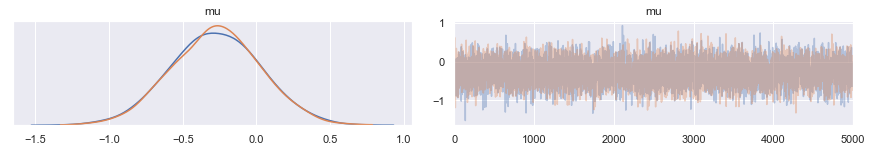

In [18]:
with model_1:
    trace_m1 = pm.sample(MET_STEPS, step=pm.Metropolis())
pm.traceplot(trace_m1[::10])

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:16<00:00, 6112.57draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c26ba9c50>,
      dtype=object)

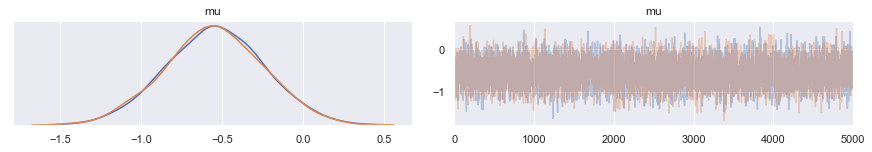

In [19]:
with model_2:
    trace_m2 = pm.sample(MET_STEPS, step=pm.Metropolis())
pm.traceplot(trace_m2[::10])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:27<00:00, 3672.81draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2549edd8>,
      dtype=object)

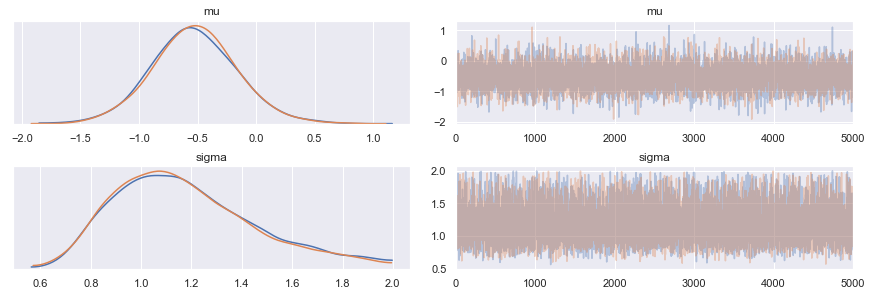

In [20]:
with model_3:
    trace_m3 = pm.sample(MET_STEPS, step=pm.Metropolis())
pm.traceplot(trace_m3[::10])

In [22]:
sample_m1 = get_values_from_trace(model_1, trace_m1)
sample_m2 = get_values_from_trace(model_2, trace_m2)
sample_m3 = get_values_from_trace(model_3, trace_m3)

## BAR estimate without augmenting

In [24]:
bayes_factor_same_nr_vars(model_1, sample_m1, model_2, sample_m2, {}, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =           -5.721
relative_change =        0.000
iteration     1: DeltaF =           -5.721
relative_change =        0.000
Convergence achieved.
Converged to tolerance of 1.924983e-14 in 2 iterations (5 function evaluations)
DeltaF =   -5.721
Running 100 bootstraps to estimate error.
log10(bf) = 2.48473 +/- 0.00097


(5.72130335770323, 0.002235724579010861)

## BAR estimate with augmenting

In [25]:
aug_mu_sigma = {}
aug_mu_sigma["x1"] = {"mu": 0, "sigma":1}
aug_mu_sigma["x2"] = {"mu": 0, "sigma":2}
aug_mu_sigma["x3"] = {"mu": 1, "sigma":1}
aug_mu_sigma["x4"] = {"mu": 1, "sigma":2}

bayes_factor_same_nr_vars(model_1, sample_m1, model_2, sample_m2, aug_mu_sigma, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =           -5.721
relative_change =        0.000
iteration     1: DeltaF =           -5.721
relative_change =        0.000
Convergence achieved.
Converged to tolerance of 1.924983e-14 in 2 iterations (5 function evaluations)
DeltaF =   -5.721
Running 100 bootstraps to estimate error.
log10(bf) = 2.48473 +/- 0.00086


(5.72130335770323, 0.001971542347667017)

## BAR estimate with two models having different number of variables

In [31]:
bayes_factor_diff_nr_vars(model_2, sample_m2, model_3, sample_m3, bootstrap=100)

Initial brackets did not actually bracket, widening them
relative_change =        1.000
iteration     0: DeltaF =            0.812
relative_change =        0.000
iteration     1: DeltaF =            0.812
relative_change =        0.000
iteration     2: DeltaF =            0.812
relative_change =        0.000
Convergence achieved.
Converged to tolerance of 6.564401e-15 in 3 iterations (8 function evaluations)
DeltaF =    0.812
Running 100 bootstraps to estimate error.
log10(bf) = -0.35257 +/- 0.00218


(-0.8118137360198665, 0.005010340664102686)

In [29]:
lower_upper_fin = fit_uniform_trace(sample_m3)
lower_upper_fin

{'mu': {'lower': -2.160102277620811, 'upper': 1.3752362404685265},
 'sigma_interval__': {'lower': -3.268128133685718, 'upper': 8.277310595853757}}